In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
def generate_wiener(end_t: float, number_of_points: int):
    t_grid, dt = np.linspace(0, end_t, number_of_points, endpoint=False, retstep=True)
    normal_cumsum = sps.norm(loc=0, scale=dt**0.5) \
                       .rvs(size=number_of_points - 1) \
                       .cumsum()
    normal_cumsum = np.insert(normal_cumsum, 0, 0)
    return t_grid, normal_cumsum

# 1. Stochastic integral simulation

In [3]:
def ito_cumsum(func, end_t: float, number_of_points: int):
    ts, ws = generate_wiener(end_t, number_of_points)
    ito_csum = (func(ts[1:]) * np.diff(ws)).cumsum()
    return ts[1:], ito_csum

In [4]:
def generate_ornstein(x_0, theta: float, sigma: float, end_t: float, number_of_points: int):
    def ornstein_integral(t):
        return np.exp(theta * t)
    ts, integral = ito_cumsum(ornstein_integral, end_t, number_of_points)
    x_t = np.exp(-theta * ts) * (x_0 + integral)
    return ts, x_t

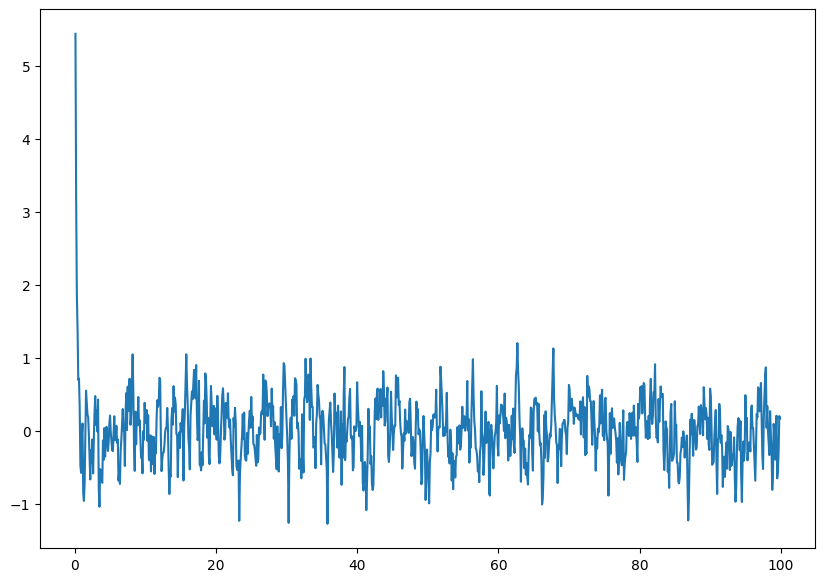

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(*generate_ornstein(10, 5, 3.5, 100, 1000))

CIR process

In [6]:
def generate_cir(x_0: float, theta: list[float], end_t, number_of_points: int):
    ts, ws = generate_wiener(end_t, number_of_points)
    th1, th2, th3 = theta
    dt = 1 / number_of_points
    
    xt = [x_0]
    for dw in np.diff(ws):
        xt_new = xt[-1] + (th1 - th2 * xt[-1]) * dt + th3 * np.sqrt(xt[-1]) * dw
        xt.append(xt_new)
    
    return ts, xt

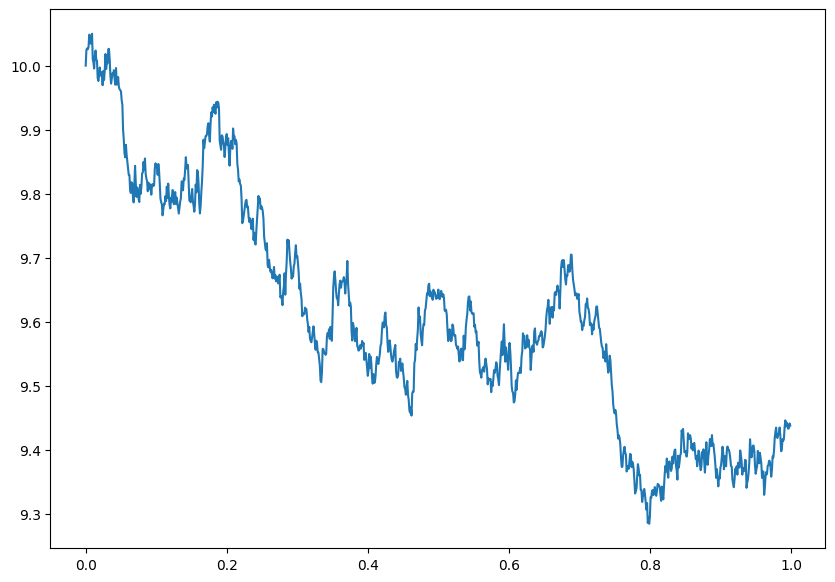

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

ts, xt = generate_cir(10, [2., 0.2, 0.15], 1, 1000)

ax.plot(ts, xt)

BSM

In [8]:
def generate_bsm(x_0: float, theta: list[float], end_t, number_of_points: int):
    ts, ws = generate_wiener(end_t, number_of_points)
    th1, th2 = theta
    xt = x_0 * np.exp( (th1 - th2**2 / 2) * ts + th2 * ws )
    return ts, xt

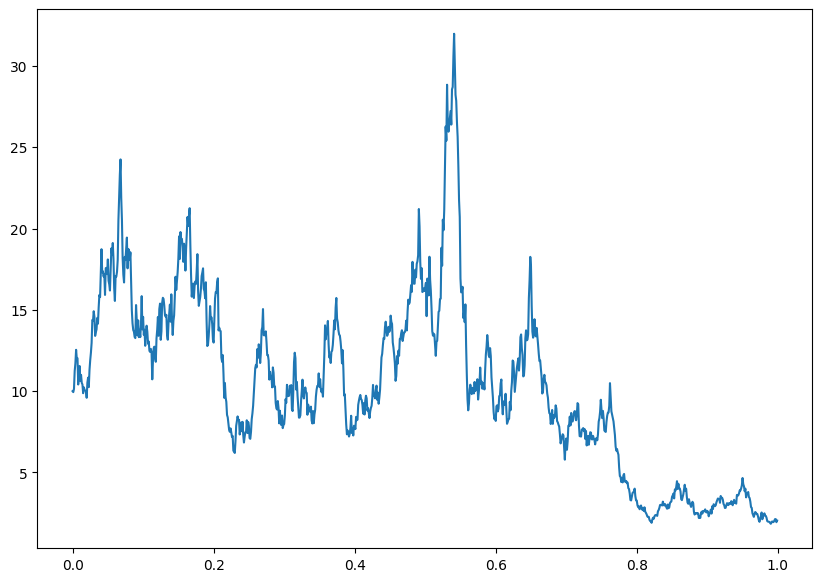

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(*generate_bsm(10, [1, 2], 1, 1000))

# 2. CIR confidence interval

In [10]:
def get_bounds(x_0, theta: list[float], t_grid: np.ndarray, alpha: float = 0.05):
    th1, th2, th3 = theta
    exp = np.exp(-th2 * t_grid)
    k = 4 * th1 / th3**2
    zeta = th3**2 * (1 - exp) / (4 * th2)
    lmda = 4 * th2 * exp / (th3**2 * (1 - exp)) * x_0
    xi = sps.norm.ppf(1 - alpha / 2)
    pm = np.array([-1, 1]).reshape(-1, 1)
    return zeta * (k + lmda + pm * xi * np.sqrt(2 * (k + 2 * lmda)))

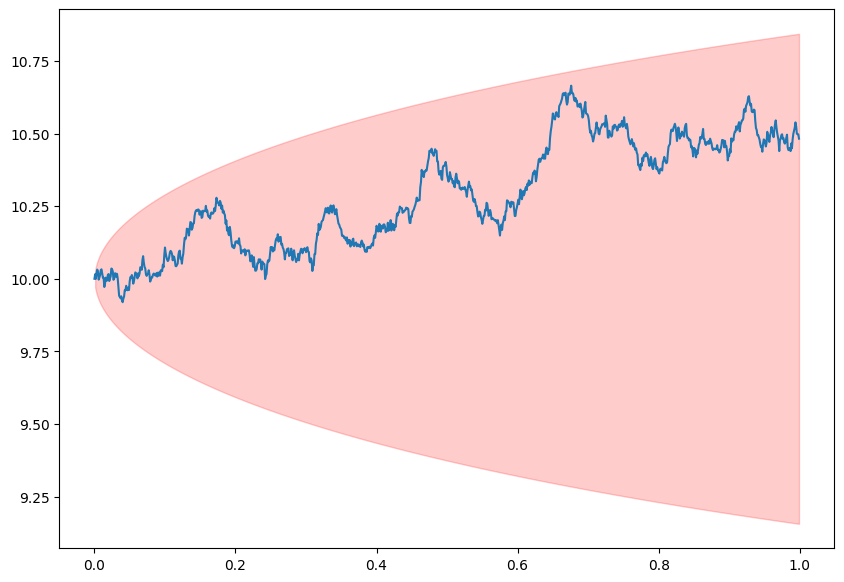

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

x_0 = 10
theta = [2., 0.2, 0.15]

ts, cir = generate_cir(x_0, theta, 1, 1000)
bounds = get_bounds(x_0, theta, ts[1:], alpha=0.05)

ax.plot(ts, cir)
ax.fill_between(ts[1:], *bounds, color='r', alpha=0.2)

# 3

In [12]:
def generate_ornstein_drifted(x_0: float, theta: list[float], end_t, number_of_points: int = 100, wieners: np.ndarray = None):
    if wieners is None:
        ts, wieners = generate_wiener(end_t, number_of_points)
    else:
        ts = np.linspace(0, end_t, wieners.size)
    th1, th2, th3 = theta
    dt = 1 / ts.size
    
    xt = [x_0]
    for dw in np.diff(wieners):
        xt_new = xt[-1] + th1 * (th2 - xt[-1]) * dt + th3 * dw
        xt.append(xt_new)
    
    return ts, xt

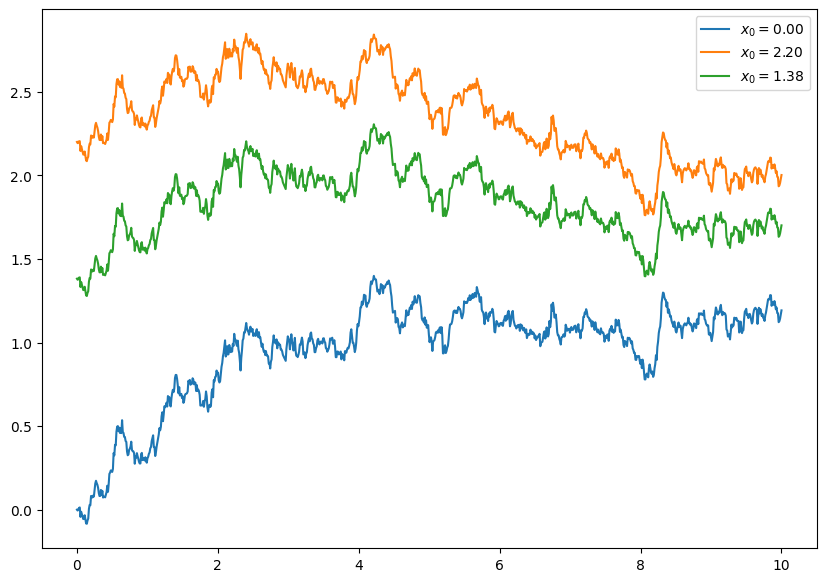

In [13]:
theta, mu, sigma = 1, 1.2, 0.3

initials = (0, 2.2, sps.norm(mu, sigma / (2 * theta)**0.5).rvs())

fig, ax = plt.subplots(figsize=(10, 7))

ts, ws = generate_wiener(end_t=10, number_of_points=1000)

for x_0 in initials:
    
    ts, xt = generate_ornstein_drifted(x_0, [theta, mu, sigma], 10, wieners=ws)
    ax.plot(ts, xt, label=r'$x_0 = ' + f'{x_0:.2f}$')
    
ax.legend()

# 4

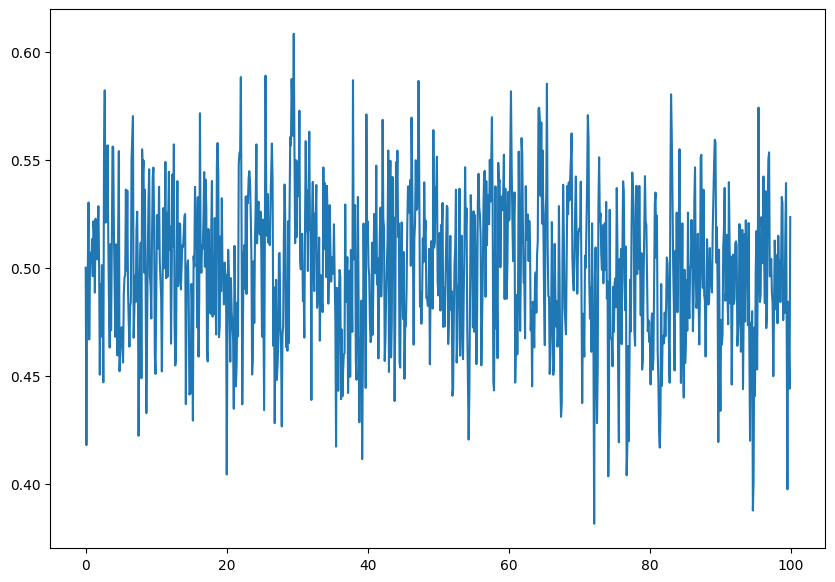

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(*generate_ornstein_drifted(0.5, [555, 0.5, 0.1], 100, 1000))